# DL Final Project code

In [ ]:
## CODE FOR DEEP LEARNING FINAL PROJECT

import math
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import csv

from sklearn.preprocessing import normalize, minmax_scale
from sklearn.manifold import TSNE

def relu(x):
    return np.maximum(x, 0)

def deriv_relu(x):
    return (x > 0).astype(x.dtype)

def np_log(x):
    return np.log(np.clip(x, 1e-6, 1e+6))

# settings for matplotlib
cmap = plt.get_cmap('viridis')

In [ ]:
## DEFINING NEURAL NETWORK CLASS

# NTK simulation, reversible pruning, initialization modes, Langevin dynamics

class NN:
  def __init__(self, M, d):
    self.M, self.d = M, d

    self.W_init = np.random.randn(M, d)
    self.a_init = 2 * np.random.binomial(1, 0.5, M).astype('float64') - 1

    self.W, self.a = copy.deepcopy(self.W_init), copy.deepcopy(self.a_init)
    self.W_ntk, self.a_ntk = copy.deepcopy(self.W_init), copy.deepcopy(self.a_init)

    self.mask = np.ones(M).astype('float64')
    self.dW, self.da = None, None
    self.dW_ntk, self.da_ntk = None, None

  def reinitialize(self): # reinitialize before set_mask
    self.W, self.a = copy.deepcopy(self.W_init), copy.deepcopy(self.a_init)
    self.W_ntk, self.a_ntk = copy.deepcopy(self.W_init), copy.deepcopy(self.a_init)

  def random_initialize(self): # full reinitialization, do not use
    self.W_init = np.random.randn(M, d)
    self.a_init = 2 * np.random.binomial(1, 0.5, M).astype('float64') - 1
    self.W, self.a = copy.deepcopy(self.W_init), copy.deepcopy(self.a_init)
    self.W_ntk, self.a_ntk = copy.deepcopy(self.W_init), copy.deepcopy(self.a_init)

  def set_mask(self, mask):
    self.mask = mask
    self.a = np.multiply(self.a, self.mask)

  def get_mask(self):
    return self.mask

  def get_params(self):
    return self.W, np.multiply(self.a, self.mask)

  def get_grad(self):
    return self.dW, np.multiply(self.da, self.mask)

  def get_params_ntk(self):
    return self.W_ntk, np.multiply(self.a_ntk, self.mask)

  def get_grad_ntk(self):
    return self.dW_ntk, np.multiply(self.da_ntk, self.mask)

  def forward(self, x):
    pre = np.matmul(self.W, x) # pre-activation M*n
    yhat = np.matmul(self.a, relu(pre)) / math.sqrt(self.M)
    return yhat

  def update(self, x, y, train = True, temp = 0): # x is d*n
    n = len(y)
    pre = np.matmul(self.W, x) # pre-activation M*n
    yhat = np.matmul(self.a, relu(pre)) / math.sqrt(self.M) # prediction
    loss = np.mean(np.square(yhat - y))

    if train == True:

      self.dW = np.matmul(np.multiply(np.multiply(deriv_relu(pre), yhat - y), np.transpose([self.a])),
                          np.transpose(x)) * 2 / (n * math.sqrt(self.M))
      self.da = np.matmul(relu(pre), yhat - y) * 2 / (n * math.sqrt(self.M))

      self.W -= lr * self.dW + math.sqrt(2 * lr * temp) * np.random.randn(M, d)
      self.a -= lr * np.multiply(self.da, self.mask) + math.sqrt(2 * lr * temp) * np.random.randn(M)
      # all self.a instances are already masked

    return loss

  def varcheck(self, x, y): # returns A[r, i]
    n = len(y)
    pre = np.matmul(self.W, x)
    yhat = np.matmul(self.a, relu(pre)) / math.sqrt(self.M)
    return np.multiply(np.multiply(deriv_relu(pre), yhat - y), np.transpose([self.a])) * 2 / (n * math.sqrt(self.M))

  def update_ntk(self, x, y, train = True): # x is d*n
    n = len(y)
    pre_init = np.matmul(self.W_init, x) # fixed pre-activation for neural tangent kernel
    yhat = np.matmul(self.a_init, np.multiply(deriv_relu(pre_init), np.matmul(self.W_ntk, x))) / math.sqrt(self.M) # prediction
    loss = np.mean(np.square(yhat - y))

    if train == True:

      self.dW_ntk = np.matmul(np.multiply(np.multiply(deriv_relu(pre_init), yhat - y), np.transpose([self.a_init])),
                          np.transpose(x)) * 2 / (n * math.sqrt(self.M))
      self.da_ntk = np.matmul(relu(pre_init), yhat - y) * 2 / (n * math.sqrt(self.M))

      self.W_ntk -= lr * self.dW_ntk
      self.a_ntk -= lr * np.multiply(self.da_ntk, self.mask) # all self.a instances are already masked

    return loss

In [ ]:
## SIMULATING TRAIN AND TEST DATASETS

d = 50 # data dim
n_train = 3000
n_test = 3000

M = 1000 # network width
max_epochs = 2000
lr = 5

# check_epoch = [0, 30, 100, 300, 999] # demystifying magnitude increase

M_teacher = M
teacher = NN(M_teacher, d)

def fun(x):
  # return np.abs(np.sum(x)) ** (2/3) + 0.2 * np.random.randn()
  return teacher.forward(x) + 0.1 * np.random.randn()

x_train = normalize(np.random.randn(d, n_train), axis = 0, norm = 'l2')
y_train = np.apply_along_axis(fun, 0, x_train)

x_test = normalize(np.random.randn(d, n_test), axis = 0, norm = 'l2')
y_test = np.apply_along_axis(fun, 0, x_test)

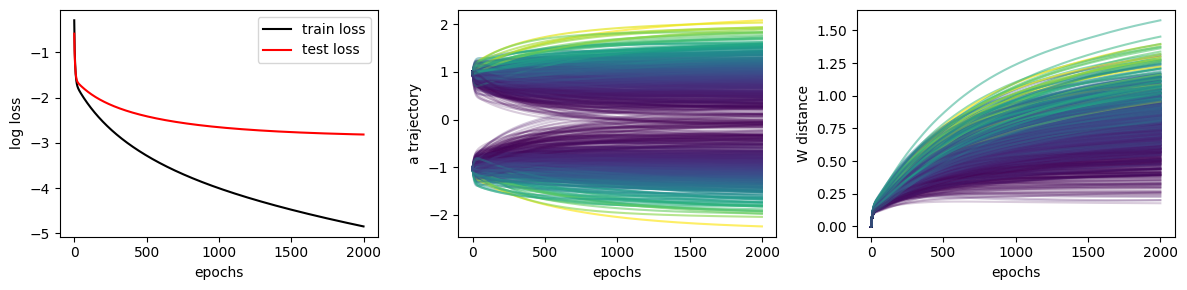

In [ ]:
## BASE TRAINING

model = NN(M, d)

train_plot = []
test_plot = []
hist_grad = [] # max_epochs * M, L^2 norm of gradients
hist_a = [] # max_epochs * M, second layer
# w_plot.append(copy.deepcopy(W[0, :])) # record 0th neuron

for epoch in range(max_epochs):

  W, a = copy.deepcopy(model.get_params())
  hist_a.append(a)

  train_loss = model.update(x_train, y_train)
  test_loss = model.update(x_test, y_test, train = False)

  train_plot.append(train_loss)
  test_plot.append(test_loss)
  # print('train loss: {:.3f} \t test loss: {:.3f}'.format(train_loss, test_loss))

  dW, da = copy.deepcopy(model.get_grad())
  hist_grad.append(np.linalg.norm(W - model.W_init, axis = 1))
  # changed from gradient summing to explicitly recording |delta W|

hist_a = np.asarray(hist_a)
hist_grad = np.asarray(hist_grad)

best_train_full = np.min(np.asarray(train_plot)) # for later
best_test_full = np.min(np.asarray(test_plot))

plt.figure(figsize=(12,3))

# show loss graph
plt.subplot(1, 3, 1)

plt.plot(range(max_epochs), np_log(train_plot), 'k', label = 'train loss')
plt.plot(range(max_epochs), np_log(test_plot), 'r', label = 'test loss')
plt.legend()
plt.xlabel('epochs'); plt.ylabel('log loss')

# show a evolution colored by gradient size at gradclip # subsumed by col_a
plt.subplot(1, 3, 2)

# gradclip = max_epochs # col_grad = minmax_scale(hist_grad[gradclip - 1, :])
# col_grad = minmax_scale(np.sum(hist_grad, axis = 0))

col_a = np.square(2 * minmax_scale(hist_a[max_epochs - 1, :]) - 1)

for i in range(M):
  plt.plot(range(max_epochs), hist_a[:, i], color = cmap(col_a[i]), alpha = 0.2 + col_a[i] * 0.5)

plt.xlabel('epochs'); plt.ylabel('a trajectory')

# show gradient size evolution colored by final a
plt.subplot(1, 3, 3)

for i in range(M):
  plt.plot(range(max_epochs), hist_grad[:, i], color = cmap(col_a[i]), alpha = 0.2 + col_a[i] * 0.5)

plt.xlabel('epochs'); plt.ylabel('W distance')

plt.tight_layout()
plt.show()

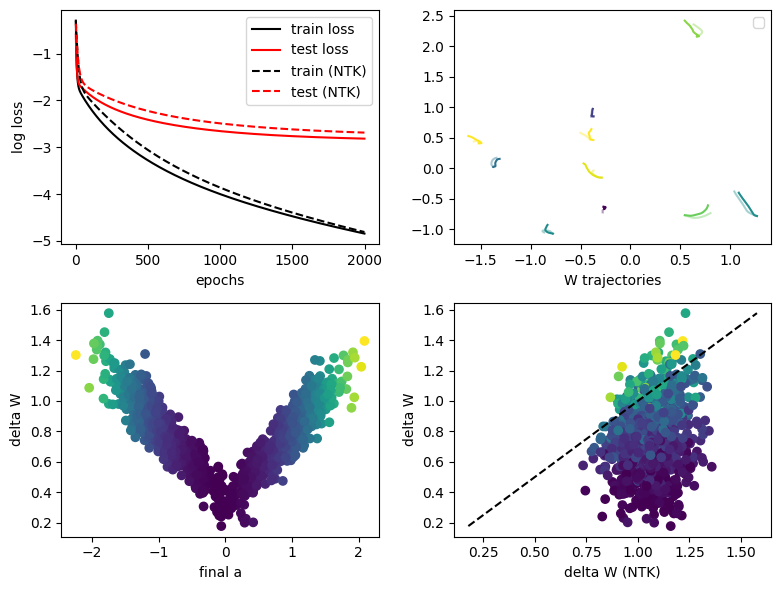

In [ ]:
## COMPARING NEURON TRAJECTORIES WITH NTK

num = 5 # how many neurons of each type to display
model.reinitialize()
index = np.argpartition(np.abs(hist_a[max_epochs - 1, :]), - num)[- num:] # add top neurons

while(len(index) < 2 * num): # add random neurons
  k = random.randrange(M)
  if k not in index:
    index = np.append(index, k)

train_plot = []
test_plot = []
train_plot_ntk = []
test_plot_ntk = []
hist_W = []
hist_W_ntk = []

for epoch in range(max_epochs):

  W, a = copy.deepcopy(model.get_params())
  W_ntk, a_ntk = copy.deepcopy(model.get_params_ntk())
  hist_W.append(copy.deepcopy(W[index, :]))
  hist_W_ntk.append(copy.deepcopy(W_ntk[index, :]))

  train_loss = model.update(x_train, y_train)
  test_loss = model.update(x_test, y_test, train = False)

  train_loss_ntk = model.update_ntk(x_train, y_train)
  test_loss_ntk = model.update_ntk(x_test, y_test, train = False)

  train_plot.append(train_loss)
  test_plot.append(test_loss)
  train_plot_ntk.append(train_loss_ntk)
  test_plot_ntk.append(test_loss_ntk)

hist_W = np.asarray(hist_W)
hist_W_ntk = np.asarray(hist_W_ntk)

plt.figure(figsize=(8, 6))

# show loss graph on log scale
plt.subplot(2, 2, 1)

plt.plot(range(max_epochs), np_log(train_plot), 'k', label = 'train loss')
plt.plot(range(max_epochs), np_log(test_plot), 'r', label = 'test loss')
plt.plot(range(max_epochs), np_log(train_plot_ntk), 'k--', label = 'train (NTK)')
plt.plot(range(max_epochs), np_log(test_plot_ntk), 'r--', label = 'test (NTK)')
plt.legend()

plt.xlabel('epochs'); plt.ylabel('log loss')

# show top #num and random #num neurons vs NTK
plt.subplot(2, 2, 2)

for i in range(2 * num):
  plt.plot([a[i][0] for a in hist_W], [a[i][1] for a in hist_W], color = cmap(col_a[index[i]]))
  plt.plot([a[i][0] for a in hist_W_ntk], [a[i][1] for a in hist_W_ntk], color = cmap(col_a[index[i]]), alpha = 0.4)
plt.legend()

plt.xlabel('W trajectories')

delta_W = np.linalg.norm(model.W - model.W_init, axis = 1)
delta_W_ntk = np.linalg.norm(model.W_ntk - model.W_init, axis = 1)

# plot a against delta_W
plt.subplot(2, 2, 3)
plt.scatter(hist_a[max_epochs - 1, :], delta_W, c = col_a)

plt.xlabel('final a'); plt.ylabel('delta W')

# plot delta_W_ntk against delta_W colored by a
plt.subplot(2, 2, 4)
plt.plot([np.min(delta_W), np.max(delta_W)], [np.min(delta_W), np.max(delta_W)], 'k--')
plt.scatter(delta_W_ntk, delta_W, c = col_a)

plt.xlabel('delta W (NTK)'); plt.ylabel('delta W')

plt.tight_layout()
plt.show()

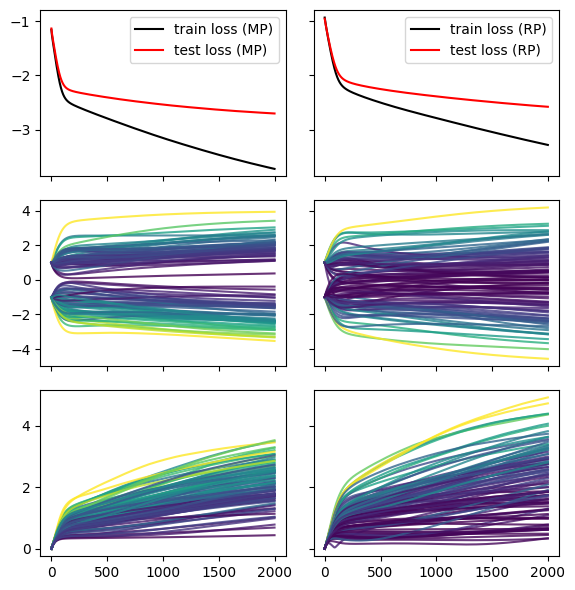

In [ ]:
# COMPARING MAGNITUDE AND RANDOM PRUNING (ONE INSTANCE)

m = 100 # fix a subnetwork size

mask_top = np.zeros(M)
mask_top[np.argpartition(np.abs(hist_a[max_epochs - 1, :]), - m)[-m:]] = 1 # magnitude pruning for |a|

mask_rand = np.zeros(M)
mask_rand[random.sample(range(M), m)] = 1 # random pruning
# mask_delta[np.argpartition(delta_W, - m)[-m:]] = 1 # delta-pruning for W: slightly worse than MP

varcheck_top = []
varcheck_rand = []
target_top = random.choice([t for t in range(M) if mask_top[t] == 1]) # mask_top.tolist().index(1)
target_rand = random.choice([t for t in range(M) if mask_rand[t] == 1])

fig, ax = plt.subplots(3, 2, sharex = 'col', sharey = 'row', figsize = (6, 6))

for mode in range(2):

  if mode == 0:
    model.reinitialize()
    model.set_mask(mask_top)
  else:
    model.reinitialize()
    model.set_mask(mask_rand)

  train_plot_sub = []
  test_plot_sub = []
  hist_grad_sub = []
  hist_a_sub = []

  for epoch in range(max_epochs):

#    if epoch in check_epoch:
#      if mode == 0:
#        varcheck_top.append(copy.deepcopy(model.varcheck(x_train, y_train)[target_top, :])) # demystifying magnitude increase
#      else:
#        varcheck_rand.append(copy.deepcopy(model.varcheck(x_train, y_train)[target_rand, :])) # demystifying magnitude increase

    W, a = copy.deepcopy(model.get_params())
    hist_a_sub.append(a)

    train_loss = model.update(x_train, y_train)
    test_loss = model.update(x_test, y_test, train = False)

    train_plot_sub.append(train_loss)
    test_plot_sub.append(test_loss)
    # print('train loss: {:.3f} \t test loss: {:.3f}'.format(train_loss, test_loss))

    dW, da = copy.deepcopy(model.get_grad())
    hist_grad_sub.append(np.linalg.norm(W - model.W_init, axis = 1))

  hist_a_sub = np.asarray(hist_a_sub)
  hist_grad_sub = np.asarray(hist_grad_sub)

  if mode == 0: # for later
    delta_W_top = np.linalg.norm(model.W - model.W_init, axis = 1)
    hist_a_top = copy.deepcopy(hist_a_sub)
  else:
    delta_W_rand = np.linalg.norm(model.W - model.W_init, axis = 1)
    hist_a_rand = copy.deepcopy(hist_a_sub)

  ax[0, mode].plot(range(max_epochs), np_log(train_plot_sub), 'k', label = 'train loss ({})'.format((1 - mode) * 'MP' + mode * 'RP'))
  ax[0, mode].plot(range(max_epochs), np_log(test_plot_sub), 'r', label = 'test loss ({})'.format((1 - mode) * 'MP' + mode * 'RP'))
  ax[0, mode].legend()

  col_a_sub = np.square(2 * minmax_scale(hist_a_sub[max_epochs - 1, :]) - 1)

  for i in np.where(model.get_mask() == 1)[0]:
    ax[1, mode].plot(range(max_epochs), hist_a_sub[:, i], color = cmap(col_a_sub[i]), alpha = 0.8)

  for i in np.where(model.get_mask() == 1)[0]:
    ax[2, mode].plot(range(max_epochs), hist_grad_sub[:, i], color = cmap(col_a_sub[i]), alpha = 0.8)

fig.tight_layout()
fig.show()

In [ ]:
## UNDERSTANDING MAGNITUDE INCREASE

varcheck_top_full = [] # reconstructing original A history of selected top neuron
varcheck_rand_full = [] # reconstructing original A history of selected rand neuron

model.reinitialize()
model.set_mask(np.ones(M).astype('float64'))

for epoch in range(max_epochs):

  if epoch in check_epoch:
    varcheck_top_full.append(copy.deepcopy(model.varcheck(x_train, y_train)[target_top, :]))
    varcheck_rand_full.append(copy.deepcopy(model.varcheck(x_train, y_train)[target_rand, :]))

  train_loss = model.update(x_train, y_train)
  test_loss = model.update(x_test, y_test, train = False)

# check_epoch = [0, 30, 100, 300, 999]

# fig, ax = plt.subplots(1, 2, sharey = 'row', figsize = (8, 4))
# ax[0].hist(varcheck_top[i][varcheck_top[i] != 0]) # zero values are due to deriv_relu
# ax[1].hist(varcheck_top_full[i][varcheck_top_full[i] != 0])
# fig.show()

i = 3 # i in range(len(check_epoch))

print(np.linalg.norm(np.matmul(varcheck_top, np.transpose(x_train)), axis = 1))
print(np.linalg.norm(np.matmul(varcheck_top_full, np.transpose(x_train)), axis = 1))
# full model norm(dW) dies off much quicker due to smaller loss

plt.scatter(varcheck_top_full[i], varcheck_top[i])
plt.gca().set_aspect('equal')
plt.show()

ValueError: ignored

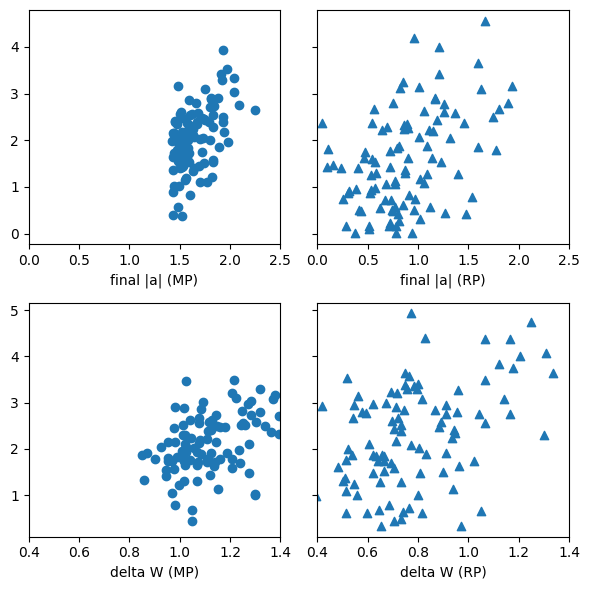

In [ ]:
figcor, axcor = plt.subplots(2, 2, sharex = None, sharey = 'row', figsize = (6, 6))

axcor[0, 0].scatter(np.abs(hist_a[max_epochs - 1, mask_top == 1]), np.abs(hist_a_top[max_epochs - 1, mask_top == 1]))
axcor[0, 0].set_xlim([0, 2.5])
axcor[0, 0].set_xlabel('final |a| (MP)')
axcor[0, 1].scatter(np.abs(hist_a[max_epochs - 1, mask_rand == 1]), np.abs(hist_a_rand[max_epochs - 1, mask_rand == 1]), marker = '^')
axcor[0, 1].set_xlim([0, 2.5])
axcor[0, 1].set_xlabel('final |a| (RP)')

axcor[1, 0].scatter(delta_W[mask_top == 1], delta_W_top[mask_top == 1])
axcor[1, 0].set_xlim([0.4, 1.4])
axcor[1, 0].set_xlabel('delta W (MP)')
axcor[1, 1].scatter(delta_W[mask_rand == 1], delta_W_rand[mask_rand == 1], marker = '^')
axcor[1, 1].set_xlim([0.4, 1.4])
axcor[1, 1].set_xlabel('delta W (RP)')

figcor.tight_layout()
figcor.show()

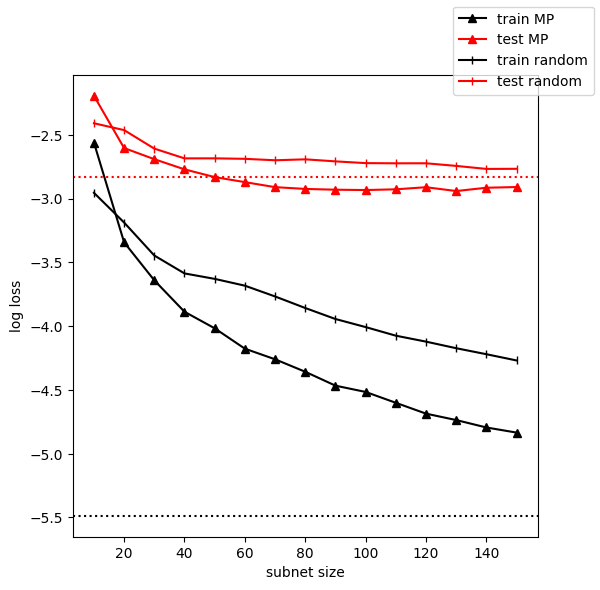

In [ ]:
## COMPARING MAGNITUDE AND RANDOM PRUNING (ACROSS SUBNET SIZES)
## takes time to run

m_range = [20, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

rand_shuffle = np.asarray(range(M))
random.shuffle(rand_shuffle)

best_train = [[], []] # [[top], [rand]]
best_test = [[], []]

fig, ax = plt.subplots(figsize = (6,6))

for m in m_range:
  for mode in range(2):

    if mode == 0:
      mask_top = np.zeros(M)
      mask_top[np.argpartition(np.abs(hist_a[max_epochs - 1, :]), - m)[-m:]] = 1

      model.reinitialize()
      model.set_mask(mask_top)

    else:
      mask_rand = np.zeros(M)
      mask_rand[rand_shuffle[:m]] = 1

      model.reinitialize()
      model.set_mask(mask_rand)

    train_plot_sub = []
    test_plot_sub = []

    for epoch in range(max_epochs):
      train_loss = model.update(x_train, y_train)
      test_loss = model.update(x_test, y_test, train = False)

      train_plot_sub.append(train_loss)
      test_plot_sub.append(test_loss)

    best_train[mode].append(np.min(np.asarray(train_plot_sub)))
    best_test[mode].append(np.min(np.asarray(test_plot_sub)))

ax.plot(m_range, np_log(best_train[0]), 'k-^', label = 'train MP')
ax.plot(m_range, np_log(best_test[0]), 'r-^', label = 'test MP')
ax.plot(m_range, np_log(best_train[1]), 'k-|', label = 'train random')
ax.plot(m_range, np_log(best_test[1]), 'r-|', label = 'test random')
ax.axhline(y = np_log(best_train_full), color = 'k', linestyle = ':')
ax.axhline(y = np_log(best_test_full), color = 'r', linestyle = ':')
fig.legend()
ax.set_xlabel('subnet size'); ax.set_ylabel('log loss')

fig.show()

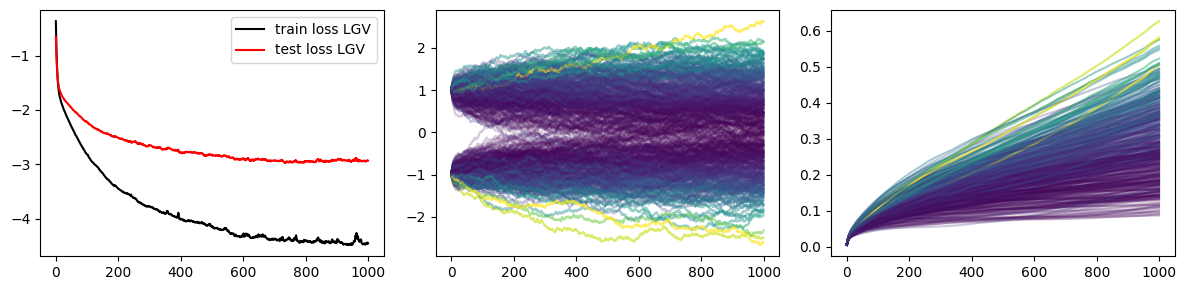

In [ ]:
## LANGEVIN DYNAMICS

temp = 2e-5

model.reinitialize()
model.set_mask(np.ones(M).astype('float64'))

train_plot_lgv = []
test_plot_lgv = []
hist_grad_lgv = [] # max_epochs * M, L^2 norm of gradients
hist_a_lgv = [] # max_epochs * M, second layer
# w_plot.append(copy.deepcopy(W[0, :])) # record 0th neuron

for epoch in range(max_epochs):

  W, a = copy.deepcopy(model.get_params())
  hist_a_lgv.append(a)

  train_loss_lgv = model.update(x_train, y_train, temp = temp)
  test_loss_lgv = model.update(x_test, y_test, train = False, temp = temp)

  train_plot_lgv.append(train_loss_lgv)
  test_plot_lgv.append(test_loss_lgv)
  # print('train loss: {:.3f} \t test loss: {:.3f}'.format(train_loss, test_loss))

  dW, da = copy.deepcopy(model.get_grad())
  hist_grad_lgv.append(np.linalg.norm(W - model.W_init, axis = 1))

hist_a_lgv = np.asarray(hist_a_lgv)
hist_grad_lgv = np.asarray(hist_grad_lgv)

best_train_full_lgv = np.min(np.asarray(train_plot_lgv))
best_test_full_lgv = np.min(np.asarray(test_plot_lgv))

plt.figure(figsize=(12,3))

plt.subplot(1, 3, 1)

plt.plot(range(max_epochs), np_log(train_plot_lgv), 'k', label = 'train loss LGV')
plt.plot(range(max_epochs), np_log(test_plot_lgv), 'r', label = 'test loss LGV')
plt.legend()

plt.subplot(1, 3, 2)

col_a = np.square(2 * minmax_scale(hist_a_lgv[max_epochs - 1, :]) - 1)

for i in range(M):
  plt.plot(range(max_epochs), hist_a_lgv[:, i], color = cmap(col_a[i]), alpha = 0.2 + col_a[i] * 0.5)

plt.subplot(1, 3, 3)

for i in range(M):
  plt.plot(range(max_epochs), np.cumsum(hist_grad_lgv[:, i]), color = cmap(col_a[i]), alpha = 0.2 + col_a[i] * 0.5)

plt.tight_layout()
plt.show()

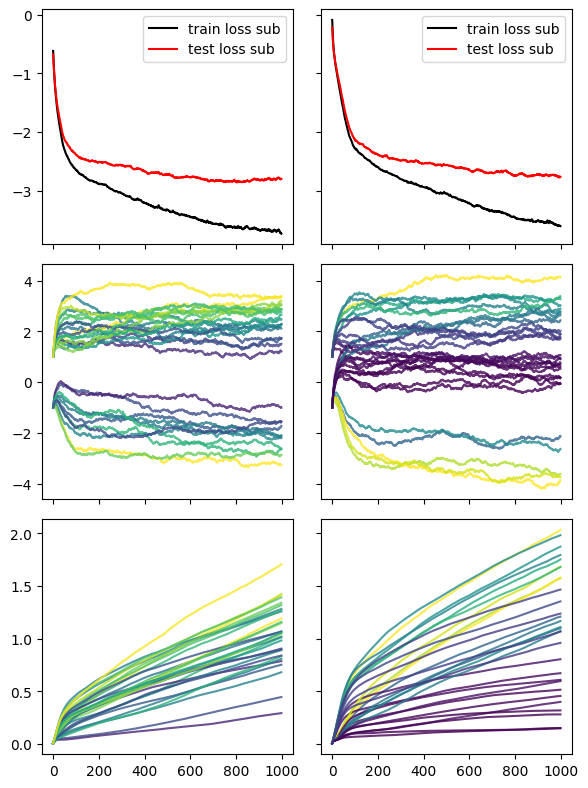

In [ ]:
## COMPARING MAGNITUDE AND RANDOM PRUNING (SINGLE INSTANCE)

m = 40 # fix a subnetwork size

mask_top = np.zeros(M)
mask_top[np.argpartition(np.abs(hist_a[max_epochs - 1, :]), - m)[-m:]] = 1 # magnitude pruning for |a|

mask_rand = np.zeros(M)
mask_rand[random.sample(range(M), m)] = 1 # random pruning

fig, ax = plt.subplots(3, 2, sharex = 'col', sharey = 'row', figsize = (6, 8))

for mode in range(2):

  if mode == 0:
    model.reinitialize()
    model.set_mask(mask_top)
  else:
    model.reinitialize()
    model.set_mask(mask_rand)

  train_plot_sub = []
  test_plot_sub = []
  hist_grad_sub = []
  hist_a_sub = []

  for epoch in range(max_epochs):

    W, a = copy.deepcopy(model.get_params())
    hist_a_sub.append(a)

    train_loss = model.update(x_train, y_train, temp = temp)
    test_loss = model.update(x_test, y_test, train = False, temp = temp)

    train_plot_sub.append(train_loss)
    test_plot_sub.append(test_loss)
    # print('train loss: {:.3f} \t test loss: {:.3f}'.format(train_loss, test_loss))

    dW, da = copy.deepcopy(model.get_grad())
    hist_grad_sub.append(np.linalg.norm(dW, axis = 1))

  hist_a_sub = np.asarray(hist_a_sub)
  hist_grad_sub = np.asarray(hist_grad_sub)

  if mode == 0: # for later
    delta_W_top = np.linalg.norm(model.W - model.W_init, axis = 1)
    hist_a_top = copy.deepcopy(hist_a_sub)
  else:
    delta_W_rand = np.linalg.norm(model.W - model.W_init, axis = 1)
    hist_a_rand = copy.deepcopy(hist_a_sub)

  ax[0, mode].plot(range(max_epochs), np_log(train_plot_sub), 'k', label = 'train loss sub')
  ax[0, mode].plot(range(max_epochs), np_log(test_plot_sub), 'r', label = 'test loss sub')
  ax[0, mode].legend()

  col_a_sub = np.square(2 * minmax_scale(hist_a_sub[max_epochs - 1, :]) - 1)

  for i in np.where(model.get_mask() == 1)[0]:
    ax[1, mode].plot(range(max_epochs), hist_a_sub[:, i], color = cmap(col_a_sub[i]), alpha = 0.8)

  for i in np.where(model.get_mask() == 1)[0]:
    ax[2, mode].plot(range(max_epochs), np.cumsum(hist_grad_sub[:, i]), color = cmap(col_a_sub[i]), alpha = 0.8)

fig.tight_layout()
fig.show()

In [ ]:
## t-SNE data generation

from google.colab import drive
drive.mount('/content/drive')

model.reinitialize()
model.set_mask(np.ones(M).astype('float64'))

record = np.array([max_epochs * 0.25, max_epochs * 0.50, max_epochs * 0.75, max_epochs - 1]).astype(int)
record_W = []

m = 100 # fix a subnetwork size

for epoch in range(max_epochs):

  if epoch in record:
    W, a = copy.deepcopy(model.get_params())
    record_W.append(W)

  if epoch == max_epochs - 1:
    W, a = copy.deepcopy(model.get_params())
    final_a = a

  train_loss = model.update(x_train, y_train)
  test_loss = model.update(x_test, y_test, train = False)

record_W = np.asarray(record_W)

index_top = np.zeros(M)
index_top[np.argpartition(np.abs(final_a), - m)[-m:]] = 1 # magnitude pruning for |a|

# record_W.shape # (4, M = 500, dim = 30)
# record_W[:, index_top == 1, :].shape # (4, m = 40, dim = 30)

with open('drive/My Drive/Colab Notebooks/DL_final/record_W.csv', 'w') as f:
    writer = csv.writer(f)
    for i in range(4):
        writer.writerows(record_W[i, :])

with open('drive/My Drive/Colab Notebooks/DL_final/record_W_sub.csv', 'w') as f:
    writer = csv.writer(f)
    for i in range(4):
        writer.writerows(record_W[i, index_top == 1, :])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


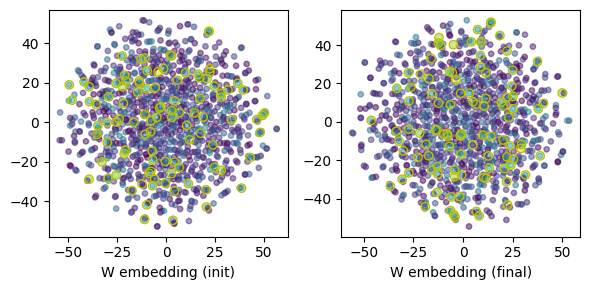

In [ ]:
## t-SNE plotting
tsne = TSNE(n_components = 2, method = 'exact', random_state = 42, perplexity = 20)

index_test = np.zeros(M)
index_test[np.argpartition(np.linalg.norm(model.W, axis = 1), - m)[-m:]] = 1

plt.figure(figsize=(6, 3))

fit_W = np.array(tsne.fit_transform(model.W_init)) # record_W[i, :] - model.W_init
plt.subplot(1, 2, 1)
plt.scatter(fit_W[:, 0], fit_W[:, 1], color = cmap(col_a), s = 15, alpha = 0.5)
plt.scatter(fit_W[index_top == 1, 0], fit_W[index_top == 1, 1], facecolor = 'none', edgecolor = 'y')
plt.xlabel('W embedding (init)')

fit_W = np.array(tsne.fit_transform(record_W[3, :])) # record_W[i, :] - model.W_init
plt.subplot(1, 2, 2)
plt.scatter(fit_W[:, 0], fit_W[:, 1], color = cmap(col_a), s = 15, alpha = 0.5)
plt.scatter(fit_W[index_top == 1, 0], fit_W[index_top == 1, 1], facecolor = 'none', edgecolor = 'y')
plt.xlabel('W embedding (final)')

# for i in range(4):
  # fit_W = np.array(tsne.fit_transform(record_W[i, :])) # record_W[i, :] - model.W_init

  # plt.subplot(1, 2, i + 1)
  # plt.scatter(fit_W[:, 0], fit_W[:, 1], color = cmap(col_a), s = 15, alpha = 0.5)
  # plt.scatter(fit_W[index_top == 1, 0], fit_W[index_top == 1, 1], facecolor = 'none', edgecolor = 'y')
  # plt.xlabel('epoch = {}'.format(250 * (i + 1)))

plt.tight_layout()
plt.show()

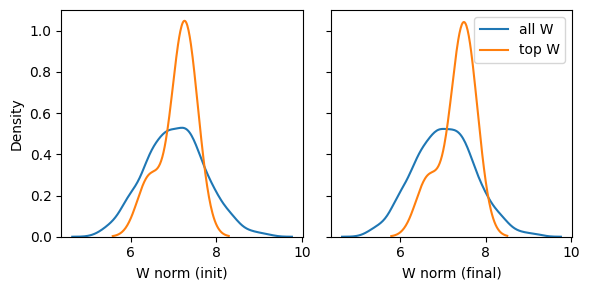

In [ ]:
## tracking pure W

model.reinitialize()
model.set_mask(np.ones(M).astype('float64'))

hist_pure = []
hist_a = []

for epoch in range(max_epochs):

  W, a = copy.deepcopy(model.get_params())
  hist_a.append(a)
  hist_pure.append(np.linalg.norm(W, axis = 1))

  train_loss = model.update(x_train, y_train)
  test_loss = model.update(x_test, y_test, train = False)

hist_a = np.asarray(hist_a)
hist_pure = np.asarray(hist_pure)
sns_top = np.argpartition(np.abs(hist_a[max_epochs - 1, :]), - num)[- num:]

figkde, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (6, 3))

sns.kdeplot(np.array(hist_pure[0, :]), ax = axes[0], label = 'all W')
sns.kdeplot(np.array(hist_pure[0, sns_top]), ax = axes[0], label = 'top W')
axes[0].set_xlabel('W norm (init)')

sns.kdeplot(np.array(hist_pure[max_epochs - 1, :]), ax = axes[1], label = 'all W')
sns.kdeplot(np.array(hist_pure[max_epochs - 1, sns_top]), ax = axes[1], label = 'top W')
axes[1].set_xlabel('W norm (final)')
axes[1].legend(loc = 'upper right')

figkde.tight_layout()
figkde.show()